In [4]:
import sys
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import sklearn 
import random 
import time
import warnings
warnings.filterwarnings("ignore")

print("Python version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Matplotlib version: {}".format(matplotlib.__version__))
print("Numpy version: {}".format(np.__version__))
print("SciPy version: {}".format(sp.__version__))
print("scikit-learn version: {}".format(sklearn.__version__))
print('-'*25)

# from subprocess import check_output
# print(check_output(['dir', '/data/']).decode('utf8'))



Python version: 3.6.2rc1 (heads/3.6:268e1fb, Jun 17 2017, 19:01:44) [MSC v.1900 64 bit (AMD64)]
Pandas version: 0.23.0
Matplotlib version: 2.2.2
Numpy version: 1.14.3
SciPy version: 1.1.0
scikit-learn version: 0.19.1
-------------------------


# Load Data Modeling Libraries

In [6]:
from sklearn import (svm, 
                     tree, 
                     linear_model, 
                     neighbors, 
                     naive_bayes,
                    ensemble, discriminant_analysis,
                    gaussian_process)
# from xgboost import XGBClassifier # need to fix
# import xgboost

In [7]:
# helper methods for modeling
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

In [8]:
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

# defaults for visualization
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

# Read in data

In [9]:
data_raw = pd.read_csv('./data/train.csv')
data_val = pd.read_csv('./data/test.csv')
# will be broken into train and test
# work with copy of data so as not to hinder the original data
# deep=True copies the references to objects
data1 = data_raw.copy(deep=True) 
data_cleaner = [data1, data_val]

In [10]:
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [11]:
print(data_val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


# Check for null fields

In [12]:
print("train.csv columns with null values:")
print(data1.isnull().sum())
print("-"*10)

train.csv columns with null values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------


In [13]:
print("test.csv columns with null values:")
print(data_val.isnull().sum())
print("-"*10)

test.csv columns with null values:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


# Clean the data

In [14]:
print("train.csv median Age:", data_cleaner[0]['Age'].median())
print("test.csv median Age:", data_cleaner[1]['Age'].median())

print('-'*20)

print("train.csv mode Embarked:", data_cleaner[0]['Age'].mode())
print("test.csv mode Embarked:", data_cleaner[1]['Age'].mode()[0])

print('-'*20)

print("train.csv median Age:", data_cleaner[0]['Fare'].median())
print("test.csv median Age:", data_cleaner[1]['Fare'].median())

train.csv median Age: 28.0
test.csv median Age: 27.0
--------------------
train.csv mode Embarked: 0    24.0
dtype: float64
test.csv mode Embarked: 21.0
--------------------
train.csv median Age: 14.4542
test.csv median Age: 14.4542


In [16]:
for dataset in data_cleaner:
    # fill empty age fields with median age
    median_age = dataset['Age'].median()
    dataset['Age'].fillna(median_age, inplace=True)
    
    # fill empty vals with mode 
    mode_embarked = dataset['Embarked'].mode()[0]
    dataset['Embarked'].fillna(mode_embarked, inplace=True)
    
    # fill empty vals with median 
    median_fare = dataset['Fare'].median()
    dataset['Fare'].fillna(median_fare, inplace=True)

In [17]:
# delete any columns that do not give much information
drop_column = ['PassengerId','Cabin', 'Ticket']
data1.drop(drop_column, axis=1, inplace = True)

In [18]:
data1.info() # above columns no longer exist
data1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.7+ KB


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [19]:
print("train.csv null fields: ")
print(data1.isnull().sum())
print("-"*10)
print("test.csv null fields:")
print(data_val.isnull().sum())

train.csv null fields: 
Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
test.csv null fields:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


# Feature Engineering
- ie. making new fields to gather information 


In [20]:
for dataset in data_cleaner:
    # get discrete variables
    
    # new column that describes the family size
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch']+1
    
    # check if a person was travellinga alone 1=yes
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize']>1] = 0
    
    # split the tile from the name: so "Mr. Khan" will be "Mr." "khan"
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    
    # continuous variables line $ will be put into bins ie, a range of values
    # eg, x=$10 will be in the bin for x<=10
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

## Look at Title field

In [21]:
# clean up rare title names
print("titles:",data1['Title'].value_counts())
# look and see there is only one person titled as "Don" 

titles: Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Ms                1
Sir               1
Capt              1
Mme               1
Lady              1
the Countess      1
Jonkheer          1
Don               1
Name: Title, dtype: int64


In [22]:
stat_min = 10
# creates a true false series where
# it checks if a specific title's occurence is less than stat_min
title_names = (data1['Title'].value_counts()<stat_min)
print(title_names)

Mr              False
Miss            False
Mrs             False
Master          False
Dr               True
Rev              True
Mlle             True
Col              True
Major            True
Ms               True
Sir              True
Capt             True
Mme              True
Lady             True
the Countess     True
Jonkheer         True
Don              True
Name: Title, dtype: bool


In [24]:
# replace all the title names that are set as True above with the title as 'Misc'
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

In [25]:
# result of abvoe .apply() and lambda function
print(data1['Title'].value_counts())

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64


In [26]:
data1.info()
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin       891 non-null category
AgeBin        891 non-null category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null in

# Convert Formats
- need to convert categorical data to dummy variables for math analysis


In [27]:
label = LabelEncoder()

In [28]:
print(label.fit_transform(dataset['Sex']))

[1 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0
 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1
 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1
 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1
 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0
 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1
 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0
 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1
 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1
 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 0 0 1
 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1
 1 0 0 0 0 0 1 0 1 1 1]


In [29]:
for dataset in data_cleaner:
    # see above for what will be filled into this column
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

In [30]:
print(data1['Embarked_Code'].head())
print(data1['Title_Code'].head())
print(data1['AgeBin_Code'].head())
print(data1['FareBin_Code'].head())

0    2
1    0
2    2
3    2
4    2
Name: Embarked_Code, dtype: int64
0    3
1    4
2    2
3    4
4    3
Name: Title_Code, dtype: int64
0    1
1    2
2    1
3    2
4    2
Name: AgeBin_Code, dtype: int64
0    0
1    3
2    1
3    3
4    1
Name: FareBin_Code, dtype: int64


In [31]:
# target outcome
Target = ['Survived']

In [32]:
# independet variables/features/x
#pretty name/values for charts
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 
#coded for algorithm calculation
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] 
data1_xy =  Target + data1_x

In [33]:
# features in bins to remove continuous data
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin

In [38]:
#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy

In [34]:
data1_dummy.head()

NameError: name 'data1_dummy' is not defined

# Splitting Training and Testing Data
- train.csv data will have a 75/25 split

In [35]:
# training on features
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)

In [36]:
# training on bin features
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)

In [39]:
# training on dummy features
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)
# note (very important for analysis): 
#random_state = 0 becuase we want the same randomness for the bin features as well as the training features

In [40]:
print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


In [41]:
train1_x_bin.head()

,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


# Analysis with Statistics

In [42]:
for x in data1_x:
    # look at all not 'float64' features
    if data1[x].dtype != 'float64':
        print("Survival Correlation by: ", x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')

Survival Correlation by:  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by:  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by:  Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by:  SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by:  Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by:  FamilySize
   FamilySize  Survived
0           1  0.30

- Above block has alot of info 
- we can see what the data is tellin us:
    - more females survived than males
    - people with a pasenger class of 1 had higher change of survival
    - etc

In [43]:
# another way of looking at information
print(pd.crosstab(data1['Title'],data1[Target[0]]))

Survived    0    1
Title             
Master     17   23
Misc       15   12
Miss       55  127
Mr        436   81
Mrs        26   99


- more masters survived then dies
- more women (married or otherwsie) survived then died
- a lot of men died
- etc

In [139]:
# skip the graphing 

# Model Data
- have to teach machine how to think not what to think
- four categories of ML: classification, regression, clustering, dimensionality, reduction. 
- Tinanic Dataset is a classification type (0=died, 1=survived)

## How to Choose ML Algorithm
- __No Free Lunch Theorem (NFLT)__: there is no super algorithm, that works best in all situations
- therefore try multiple algorithms and compare with scenario
- afterwards we have to tune their parameters and compare with other MLAs again

In [44]:
# machine learning algorithms (MLA) list
# They are selected and initalized here
MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(), 
    ensemble.BaggingClassifier(), 
    ensemble.ExtraTreesClassifier(), 
    ensemble.GradientBoostingClassifier(), 
    ensemble.RandomForestClassifier(),
    
    # Gaussian Processes
    gaussian_process.GaussianProcessClassifier(), 
    
    # GLM
    linear_model.LogisticRegressionCV(), 
    linear_model.PassiveAggressiveClassifier(), 
    linear_model.RidgeClassifierCV(), 
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # Naive Bayes
    naive_bayes.BernoulliNB(), 
    naive_bayes.GaussianNB(),
    
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True), 
    svm.LinearSVC(), 
    
    # Trees
    tree.DecisionTreeClassifier(), 
    tree.ExtraTreeClassifier(), 
    
    
    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    # xgboost
    # need to import the classifier
]

In [45]:
# split dataset in cross-validation 
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=0)

In [46]:
# Create table for MLAs for comparison
MLA_columns = [
    'MLA Name', 
    'MLA Parameters', 
    'MLA Train Accuracy Mean',
    'MLA Test Accuracy Mean', 
    'MLA Test Accuracy 3*STD', 
    'MLA Time'
]
MLA_compare = pd.DataFrame(columns=MLA_columns)

In [47]:
# create an other table to compare predictions
MLA_predict = data1[Target]

In [48]:
row_index = 0
for alg in MLA:
    # set the name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # score move with cross validation
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv=cv_split)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    
    # if non-bias random sample then +/- 3 std from mean will capture 99.7% of subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3 # worst case scenario
    
    # save MLA predictions (for later use)
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1
    

In [49]:
# print and sort MLA_compare dataframe
MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837266,0.826119,0.0453876,0.0423297
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.891199,0.825746,0.0666115,0.0162218
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895131,0.822761,0.0586486,0.0181648
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.835768,0.822761,0.0493681,0.0487341
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.866667,0.822015,0.0529916,0.0768045
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.821269,0.0556221,0.00240149
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.890637,0.820149,0.0570347,0.0205571
18,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.814179,0.0574724,0.00200169
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.0690863,0.00320194
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.820412,0.81194,0.0498606,0.0949753


In [50]:
MLA_predict.head()

,Survived,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier,GaussianProcessClassifier,LogisticRegressionCV,PassiveAggressiveClassifier,RidgeClassifierCV,...,BernoulliNB,GaussianNB,KNeighborsClassifier,SVC,NuSVC,LinearSVC,DecisionTreeClassifier,ExtraTreeClassifier,LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,0,0,0,0,0,1,0,1,...,1,1,0,1,1,1,0,0,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Text(0,0.5,'Algorithm')

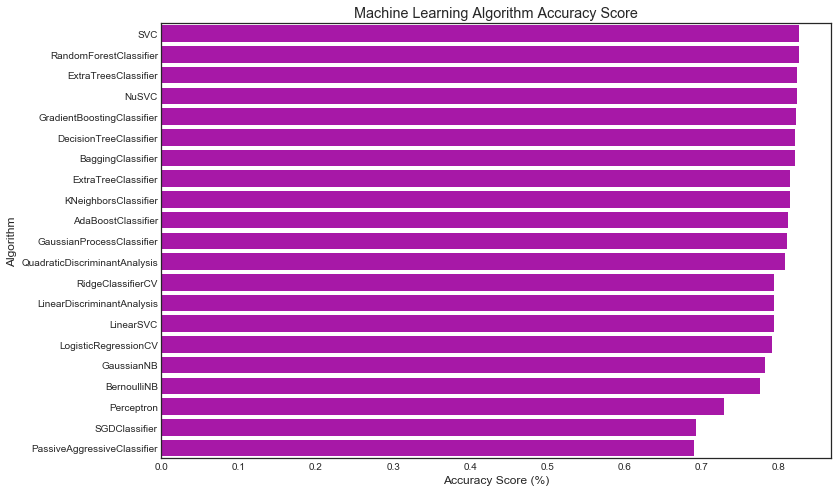

In [51]:
# graph MLA_compare dataframe
sns.barplot(x='MLA Test Accuracy Mean', y='MLA Name', data=MLA_compare, color='m')
plt.title('Machine Learning Algorithm Accuracy Score')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

## ROI (data science 101: determine baseline accuracy)
- return on investment: is it worth it to improve the model and why should we do it?
- is it even worth keeping?
- This is a binary problem (survived or died) therefore random guess will be 50/50
    - if our model does worse than 50% then we are better off using a coin for predictoins
 - 67.5% of the people died, so lets keep that as our bad model. 

## DS 101: How to create your own model
- make our own decision tree model
    - question 1: were you on the titanic?
    - question 2: are you male or female?
    - question 3: are you class 1,2,3?
    - question 4: did you embark from C,Q,S?

In [52]:
# coin flip model
for index, row in data1.iterrows():
    if random.random() > 0.5:
        data1.set_value(index, 'Random_Predict', 1)
    else:
        data1.set_value(index, 'Random_Predict', 0)
        
data1['Random_Score'] = 0 #assume prediction wrong
data1.loc[(data1['Survived'] == data1['Random_Predict']), 'Random_Score'] = 1 #set to 1 for correct prediction
print('Coin Flip Model Accuracy: {:.2f}%'.format(data1['Random_Score'].mean()*100))
print('Coin Flip Model Accuracy w/SciKit: {:.2f}%'.format(metrics.accuracy_score(data1['Survived'], data1['Random_Predict'])*100))

Coin Flip Model Accuracy: 50.17%
Coin Flip Model Accuracy w/SciKit: 50.17%


In [53]:
# Decision Tree model
pivot_female = data1[data1.Sex=='female'].groupby(['Sex','Pclass', 'Embarked','FareBin'])['Survived'].mean()
print('Survival Decision Tree w/Female Node: \n',pivot_female)

pivot_male = data1[data1.Sex=='male'].groupby(['Sex','Title'])['Survived'].mean()
print('\n\nSurvival Decision Tree w/Male Node: \n',pivot_male)

Survival Decision Tree w/Female Node: 
 Sex     Pclass  Embarked  FareBin        
female  1       C         (14.454, 31.0]     0.666667
                          (31.0, 512.329]    1.000000
                Q         (31.0, 512.329]    1.000000
                S         (14.454, 31.0]     1.000000
                          (31.0, 512.329]    0.955556
        2       C         (7.91, 14.454]     1.000000
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    1.000000
                Q         (7.91, 14.454]     1.000000
                S         (7.91, 14.454]     0.875000
                          (14.454, 31.0]     0.916667
                          (31.0, 512.329]    1.000000
        3       C         (-0.001, 7.91]     1.000000
                          (7.91, 14.454]     0.428571
                          (14.454, 31.0]     0.666667
                Q         (-0.001, 7.91]     0.750000
                          (7.91, 14.454]     0.500000


In [2]:
# come back to making you own model

## Tune Model with Hyper-Parameters
- In order to tune paramaeters we need to know more about the models we are using. 
- Decision Tree classifier:
    - advantages:
        - little data preparation. No normalization needed. Dummy variables need to be created and blank values need to be removed/filled. 
        - log complexity
        - can handle numeric and categorical data
        - handles multi-output problems
    - disadvantages:
        - over-complex trees which do not generalize are possible
        - are very unstable becuase small variations in the data might result in completely different tree
        - learning an optimal decision tree is NP-complete. For this reason heuristic algorithms (greedy alg) are used for locally optimal decisions
        - can't learn even simple rule like the XOR
        

In [56]:
# base model 
dtree = tree.DecisionTreeClassifier(random_state=0)
base_results = model_selection.cross_validate(dtree, data1[data1_x_bin],
                                             data1[Target], cv=cv_split)
dtree.fit(data1[data1_x_bin], data1[Target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [60]:
print("BEFORE DT Parameters: ", dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}".format(base_results['train_score'].mean()*100))
print("BEFORE DT Test w/bin score mean: {:.2f}".format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}".format(base_results['test_score'].std()*100*3))

BEFORE DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 89.51
BEFORE DT Test w/bin score mean: 82.09
BEFORE DT Test w/bin score 3*std: +/- 5.57


In [61]:
param_grid = {
    # scoring methodolopy; two supported formulas for calculating information gain
    'criterion': ['gini', 'entropy'],
    # max depth tree can grow; defalut is none
    'max_depth': [2,4,6,8,10,None],
    # seed for controling random number generator
    'random_state':[0]
}

In [63]:
# choose best model with grid search 
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), 
                                         param_grid=param_grid, 
                                         scoring='roc_auc',
                                         cv=cv_split)

In [65]:
tune_model.fit(data1[data1_x_bin], data1[Target])

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.3, train_size=0.6),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, None], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [66]:
print('AFTER DT Parameters:', tune_model.best_params_)
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))

AFTER DT Parameters: {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Training w/bin score mean: 89.35
AFTER DT Test w/bin score 3*std: +/- 5.00


# Tune Model with Feature Selection

In [67]:
print('BEFORE DT RFE Training Shape Old: ', data1[data1_x_bin].shape) 
print('BEFORE DT RFE Training Columns Old: ', data1[data1_x_bin].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))

BEFORE DT RFE Training Shape Old:  (891, 7)
BEFORE DT RFE Training Columns Old:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
BEFORE DT RFE Training w/bin score mean: 89.51
BEFORE DT RFE Test w/bin score mean: 82.09
BEFORE DT RFE Test w/bin score 3*std: +/- 5.57


In [69]:
# feature selection 
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(data1[data1_x_bin], data1[Target])
X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, data1[X_rfe], data1[Target], cv  = cv_split)

In [70]:
print('AFTER DT RFE Training Shape New: ', data1[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))

AFTER DT RFE Training Shape New:  (891, 6)
AFTER DT RFE Training Columns New:  ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code'
 'FareBin_Code']
AFTER DT RFE Training w/bin score mean: 88.16
AFTER DT RFE Test w/bin score mean: 83.06
AFTER DT RFE Test w/bin score 3*std: +/- 6.22


# Now we can tune the rfe model with GridSearchCV

In [71]:
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
rfe_tune_model.fit(data1[X_rfe], data1[Target])

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.3, train_size=0.6),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, None], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [72]:
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))

AFTER DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT RFE Tuned Training w/bin score mean: 89.39
AFTER DT RFE Tuned Test w/bin score mean: 87.34
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 6.21


## Graph the DT

In [79]:
import graphviz 
dot_data = tree.export_graphviz(dtree, out_file=None, 
                                feature_names = data1_x_bin, class_names = True,
                                filled = True, rounded = True)


In [84]:
graph = graphviz.Source(dot_data) 
# graph # not working

# Validate and Implement
- compare algorithm predictions with each other where 1=eactly similar

In [86]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

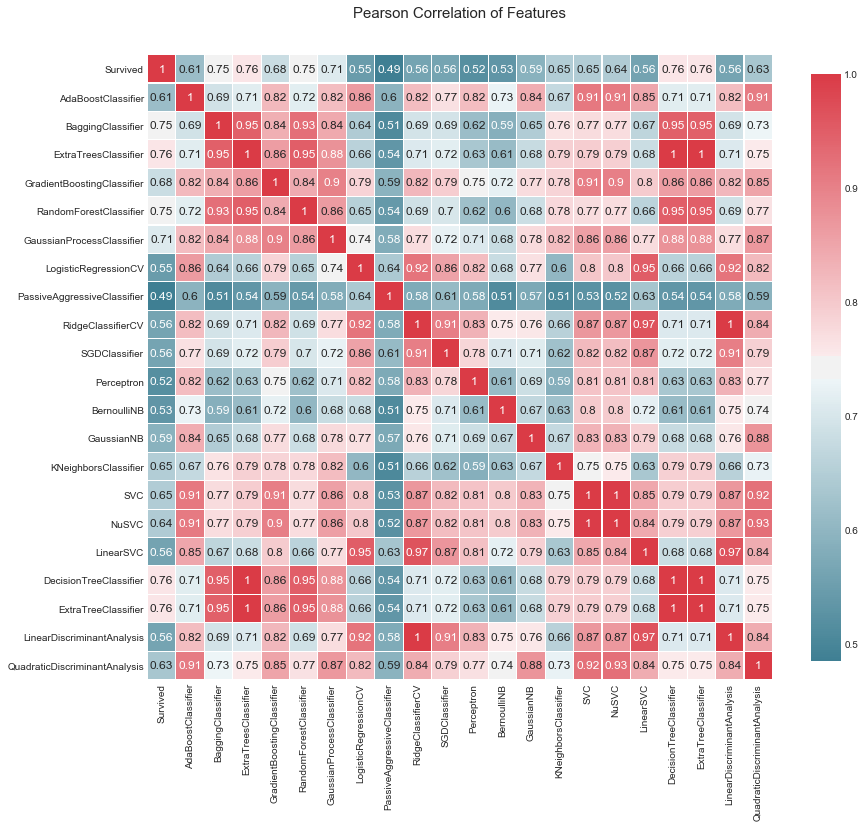

In [87]:
correlation_heatmap(MLA_predict)

In [88]:
# can use a voting classifer to choose best one
vote_est = [
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),
    
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    ('lr', linear_model.LogisticRegressionCV()),
    
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    ('knn', neighbors.KNeighborsClassifier()),
    
    ('svc', svm.SVC(probability=True)),   
]

In [89]:
# hard vote: majorith rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, data1[data1_x_bin], data1[Target], cv  = cv_split)
vote_hard.fit(data1[data1_x_bin], data1[Target])

VotingClassifier(estimators=[('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)), ('bc', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimator...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [90]:
print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))

Hard Voting Training w/bin score mean: 86.70
Hard Voting Test w/bin score mean: 82.28
Hard Voting Test w/bin score 3*std: +/- 4.14


In [91]:
#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, data1[data1_x_bin], data1[Target], cv  = cv_split)
vote_soft.fit(data1[data1_x_bin], data1[Target])

VotingClassifier(estimators=[('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)), ('bc', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimator...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [92]:
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, data1[data1_x_bin], data1[Target], cv  = cv_split)
vote_soft.fit(data1[data1_x_bin], data1[Target])

VotingClassifier(estimators=[('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)), ('bc', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimator...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [93]:
print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))

Soft Voting Training w/bin score mean: 87.34
Soft Voting Test w/bin score mean: 82.24
Soft Voting Test w/bin score 3*std: +/- 4.48


## GridSearchCV for all models (will take time)

In [96]:
# hyper parameters tuned for all models: GridSearchCV
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

In [101]:
grid_param = [
    # AdaBoostClassifier
    [{
        'n_estimators': grid_n_estimator,
        'learning_rate': grid_learn,
        'random_state': grid_seed
    }],
    # BaggingClassifier
    [{
        'n_estimators': grid_n_estimator, 
        'max_samples': grid_ratio,
        'random_state': grid_seed
    }],
    # ExtratreesClassifier
    [{
        'n_estimators': grid_n_estimator,
        'criterion': grid_criterion,
        'max_depth': grid_max_depth,
        'random_state': grid_seed
    }],
    # GradientDoostingClassifier
    [{
        'learning_rate': [.05],
        'n_estimators': [300],
        'max_depth': grid_max_depth,
        'random_state': grid_seed
    }],
    # RandomForestClassifier
    [{
        'n_estimators': grid_n_estimator,
        'criterion': grid_criterion,
        'max_depth': grid_max_depth,
        'oob_score': [True],
        'random_state': grid_seed  
    }],
    # GaussianProcessClassifier
    [{
        'max_iter_predict': grid_n_estimator,
        'random_state': grid_seed
    }],
    # LogisticRegressionCV
    [{
        'fit_intercept': grid_bool,
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
        'random_state': grid_seed
    }],
    # BernoulliNB
    [{
        'alpha': grid_ratio,        
    }],
    # GaussianNB
    [{}],
    # KNeighborsClassifier
    [{
        'n_neighbors': [1,2,3,4,5,6,7], 
        'weights': ['uniform', 'distance'], 
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }],
    # SVC
    [{
        'C': [1,2,3,4,5],
        'gamma': grid_ratio, 
        'decision_function_shape': ['ovo', 'ovr'], 
        'probability': [True],
        'random_state': grid_seed
        
    }]
]

In [102]:
start_total = time.perf_counter()
for clf, param in zip(vote_est, grid_param):
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(data1[data1_x_bin], data1[Target])
    run = time.perf_counter() - start
    
    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 
    
run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 54.79 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 47.01 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0} with a runtime of 100.01 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 49.04 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 173.51 seconds.
The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 16.37 seconds.
The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'random_s

In [104]:
# Tune Hyper parameters

#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, data1[data1_x_bin], data1[Target], cv  = cv_split)
grid_hard.fit(data1[data1_x_bin], data1[Target])

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, data1[data1_x_bin], data1[Target], cv  = cv_split)
grid_soft.fit(data1[data1_x_bin], data1[Target])

VotingClassifier(estimators=[('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=300, random_state=0)), ('bc', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=0.25,
         n_estimators...rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [105]:
print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 84.98
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 82.43
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 5.21
----------


In [106]:
print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)

Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 84.66
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 82.31
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 4.86
----------


In [108]:
def mytree(df):
    
    #initialize table to store predictions
    Model = pd.DataFrame(data = {'Predict':[]})
    male_title = ['Master'] #survived titles

    for index, row in df.iterrows():

        #Question 1: Were you on the Titanic; majority died
        Model.loc[index, 'Predict'] = 0

        #Question 2: Are you female; majority survived
        if (df.loc[index, 'Sex'] == 'female'):
                  Model.loc[index, 'Predict'] = 1

        #Question 3A Female - Class and Question 4 Embarked gain minimum information

        #Question 5B Female - FareBin; set anything less than .5 in female node decision tree back to 0       
        if ((df.loc[index, 'Sex'] == 'female') & 
            (df.loc[index, 'Pclass'] == 3) & 
            (df.loc[index, 'Embarked'] == 'S')  &
            (df.loc[index, 'Fare'] > 8)

           ):
                  Model.loc[index, 'Predict'] = 0

        #Question 3B Male: Title; set anything greater than .5 to 1 for majority survived
        if ((df.loc[index, 'Sex'] == 'male') &
            (df.loc[index, 'Title'] in male_title)
            ):
            Model.loc[index, 'Predict'] = 1
        
        
    return Model

In [111]:
# prepare model for submission
data_val['Survived'] = mytree(data_val).astype(int)
data_val['Survived'] = grid_hard.predict(data_val[data1_x_bin])

In [114]:
# submit file
submit = data_val[['PassengerId','Survived']]
submit.to_csv("./data/submit.csv", index=False)

In [115]:
print('Validation Data Distribution: \n', data_val['Survived'].value_counts(normalize = True))
submit.sample(10)

Validation Data Distribution: 
 0    0.600478
1    0.399522
Name: Survived, dtype: float64


,PassengerId,Survived
361,1253,1
114,1006,1
414,1306,1
257,1149,0
116,1008,0
93,985,0
81,973,0
297,1189,0
100,992,1
222,1114,1
